# Example: Hopfield Networks
This example will familiarize students with [Hopfield networks](https://en.wikipedia.org/wiki/Hopfield_network), a type of artificial neural network model of [associate memory](https://en.wikipedia.org/wiki/Associative_memory_(psychology)). 

### What is a Hopfield network?
A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) is a fully connected undirected graph 
consisting of $N$ nodes, where each node in the graph has a state $s = \pm{1}$. Each node in the network is connected to every other node, but not to itself, i.e., the network has no self-loops. The weights of the connection between node $i$ and $j$, denoted as $w_{ij}\in\mathbf{W}$ are learned from data using [a Hebbian learning rule](https://en.wikipedia.org/wiki/Hebbian_theory). Unlike the [feedforward network](https://en.wikipedia.org/wiki/Feedforward_neural_network) that we looked at previously, the weights in a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) are completely specified by the memories we want to encode. Suppose we wish our network to memorize $m$-memories. Then, the weights $\mathbf{W}$ would be given by:
$$
\begin{equation*}
\mathbf{W} = \frac{1}{m}\cdot\sum_{i=1}^{m}\hat{\mathbf{s}}_{i}\otimes\hat{\mathbf{s}}_{i}^{T}
\end{equation*}
$$
where $\hat{\mathbf{s}_{i}}$ denotes the state (pixels) of the image we want to memorize, and $\otimes$ denotes the outer product. Thus, the weights are the average of all of our memories! 

### Energy
The other interesting thing about the [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) is that it is an example of an energy-based method. In particular, the energy for a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) with states $s\pm{1}$ is given by:
$$
\begin{equation*}
E(\mathbf{s}) = -\frac{1}{2}\cdot\sum_{ij}w_{ij}s_{i}s_{j} - \sum_{i}b_{i}s_{i}
\end{equation*}
$$
Finally, when updating the network, we flip states using the update rule:
$$
\begin{equation*}
s_{i}^{\prime} = \sigma\left(\sum_{j}w_{ij}s_{j}-b_{i}\right)
\end{equation*}
$$
where the activation function $\sigma$ is the `sign` function in this case.

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [9]:
include("Include.jl");

In [11]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end];

## Prerequisites
In this section, we'll load a training image dataset before training the Hopfield network. We'll save training data in the `training_image_dataset` variable.
* The `training_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`.
* The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of weird features. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

However, before we load the training data, let's set some constants that we use below. See the comment next to the constant for a description of what it is, its permissible values, units, etc.

In [125]:
number_of_training_examples = 30; # how many training examples of each number?
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
number_of_steps = 5000; # how many flips do we do?

### Select a set of `training` images, and build the `training_image_dataset`
`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then convert these to a vector vector format.

In [23]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, 28, 28, number_of_training_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ 1:number_of_training_examples
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        training_image_dictionary[i] = image_digit_array
    end
    training_image_dictionary
end;

Next, we take the images and vectorize them. Each $N\times{N}$ image array is linearized, i.e., the $N\times{N}$ array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* __What's the deal with Float32__? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory space because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/) which has different memory constraints.

In [26]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, 28*28);
            linearindex = 1;
            for row ∈ 1:28
                for col ∈ 1:28
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

## Task 1: Setup the model structure and training
In this task, we'll construct a model and then train the model, i.e., learn the model parameters, using example images encoded in the the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}`. A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) has two sets of parameters, the weight matrix $\mathbf{W}$ and the gain vector $\mathbf{b}$.

### Weights
A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) uses a special [Hebbian learning rule](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2010.01472), where the weights $w_{ij}\in\mathbf{W}$ are _encoded_ by the image (or memory) the network is trying to learn. The weights $\mathbf{W}$ are given by (for a single image):
$$
\begin{equation*}
\mathbf{W} = \hat{\mathbf{s}}\otimes\hat{\mathbf{s}}^{T}
\end{equation*}
$$
where $\hat{\mathbf{s}}$ denotes the pixel pattern of the image that we want to learn, and $\otimes$ denotes the _outer product_, i.e., $w_{ij} = \hat{s}_{i}\hat{s}_{j}$. To get the weight matrix, let's select an image and compute the state vector $\hat{\mathbf{s}}$, and then compute the inner product.
* The state vector $\mathbf{s}$ have values of $\pm{1}$, so a pixel value of `0` will get mapped to $s=$ `-1`, otherwise it will be $s=$ `1`.

In [259]:
ŝ,example_image_index = let

    example_image_index = 156; # select an image from the training dataset 
    ŝ = Array{Int64,1}(undef, number_of_pixels);
    image = training_image_dataset[example_image_index][1];

    for i ∈ 1:number_of_pixels
        pixel = image[i] |> round;
        if pixel == 0.0
            ŝ[i] = -1;
        else
            ŝ[i] = 1;
        end
    end    
    ŝ,example_image_index
end;

In [260]:
ŝ

784-element Vector{Int64}:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

Let's use [the `decode(...)` function](src/Compute.jl) to convert the state vector $\hat{\mathbf{s}}$ back into an image that we can see:

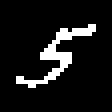

In [262]:
decode(ŝ) |> img -> Gray.(img)

Next, let's compute the weight matrix $\mathbf{W}$:

In [264]:
W = ⊗(ŝ,ŝ) .|> Int32

784×784 Matrix{Int32}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1   

Finally, we can compute the bias vector $\mathbf{b}$. Elements of the bias vector $\mathbf{b}$ can be any value between `-1` and `1`. So let's select a random $\mathbf{b}$:

In [266]:
b = let

    b = Array{Float32,1}(undef,number_of_pixels); # initialize some space
    L = -1.0; # lower bound
    U = 1.0; # upper bound

    # main
    for i ∈ 1:number_of_pixels
       f = rand();
        b[i] = f*U+(1-f)*L;
    end

    b
end;

## Task 2: Can we recover the selected image?
In this task, we'll test whether or not we can recover the test image, starting from a random state vector $\mathbf{s}_{\circ}$, by iterating the state of the network. Let's begin by initializing a random state vector $\mathbf{s}_{\circ}$.

In [268]:
sₒ = let

    sₒ = Array{Int32,1}(undef, number_of_pixels); # initialize some space
    θ = 0.60;

    for i ∈ 1:number_of_pixels
        if (rand() ≤ θ)
            sₒ[i] = -1;
        else
            sₒ[i] = 1;
        end
    end
    sₒ;
end;

What is the starting image (memory)?

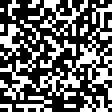

In [270]:
decode(sₒ) |> img -> Gray.(img)

### Memory recovery?
Now that we have a starting memory encoded in the state vector $\mathbf{s}_{\circ}$, let's see if we can recover the original image.
* __What do we expect to happen?__ Starting from the initial random configuration, we'll randomly select pixels and flip them (or at least evaluate the activation function). We'll store a copy of the (potentially) flipped state and compute the energy for the (potentially) flipped state. We expect the energy to decrease as we converge toward the correct image.

In [272]:
frames, energydictionary = let

    # initialize -
    frames = Dict{Int64, Array{Int32,1}}();
    energydictionary = Dict{Int64, Float32}();

    # setup -
    frames[0] = copy(sₒ); # copy the initial random state
    energydictionary[0] = energy(sₒ,W, b);

    s = copy(sₒ);
    for i ∈ 1:number_of_steps

        j = rand(1:number_of_pixels); # select a random pixel
        s[j] = sign(transpose(W[j,:])*s - b[j]);

        frames[i] = copy(s); # save a copy
        energydictionary[i] = energy(s,W, b);
    end
    

    frames, energydictionary
end;

First, does the energy decrease as we flip the states in the network? Let's plot the values in the `energydictionary::Dict{Int64, Float32}` and see.

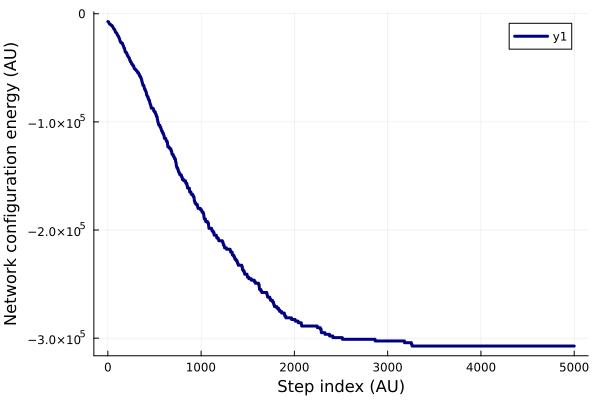

In [274]:
let
    plot(energydictionary, lw=3,c=:navy)
    xlabel!("Step index (AU)", fontsize=18)
    ylabel!("Network configuration energy (AU)", fontsize=18)
end

The energy is decreasing, but do we see the correct image?
* __Interesting__: Depending upon where we start, we should recover the original image or the anti-image of the original image. Why does the network store the anti-image?

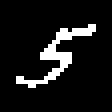

In [276]:
let
    image_index_to_view = 5000;
    s = frames[image_index_to_view];
    decode(s) |> image -> Gray.(image)
end

How many images can we store in this network? One of the super interesting features of this approach is that we can store many images in the same network! In fact, we can store $K_{max}\sim{0.14}\cdot{N}$ images. In this case, we have $N = $ `784`, so we can expect to store:

In [278]:
K_max = 0.14*number_of_pixels

109.76